# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

In [45]:
load_dotenv(override=True)
openai_api_key=os.getenv("OPENAI_API_KEY")
if(openai_api_key):
    print(f"open ai API Key starts with {openai_api_key[:8]}")
else:
    print(f"API Key does not exist")

MODEL="gpt-4.1-mini"
openai = OpenAI()
DB = "prices.db"


open ai API Key starts with sk-proj-


In [46]:
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [68]:
def get_ticket_price(city):
    print(f"Database tool called for the {city}")
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is {result[0]}" if result else "No price data available for this city"

In [69]:
get_ticket_price("hyderabad")

Database tool called for the hyderabad


'Ticket price to hyderabad is $700'

# Apply tools for the get ticket price

In [128]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}
tools = [{"type": "function", "function": price_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [130]:
def chat(message,history):
    hisotry=[{"role":h["role"],"content":h["content"]} for h in history]
    messages=[{"role":"system","content":system_message}] + history + [{"role":"user","content":message}]
    response=openai.chat.completions.create(model=MODEL,messages=messages,tools=tools)
    return response.choices[0].message.content 

gr.ChatInterface(fn=chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7933
* To create a public link, set `share=True` in `launch()`.


In [ ]:
def chat(message,history):
    history=[{"role":h["role"],"content":h["content"]} for h in history]
    messages=[{"role":"system","content":system_message}] + history + [{"role":"user","content":message}]
    response=openai.chat.completions.create(model=MODEL,messages=messages,tools=tools)
    while response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        print(f"too call is been made for {message}")
        responses=handle_tool_calls(message)
        messages.append(message)
        messages.extend(responses)
        print(f"appended response to the context window after the tool call {responses}")
        print(f"print messages after the tool call {messages}")
        response=openai.chat.completions.create(model=MODEL,messages=messages,tools=tools)
        print(f'response after the model call {response.choices[0].message.content}')
    return response.choices[0].message.content

In [ ]:
def handle_tool_calls(message):
    responses = []
    print(f"handle tool calls called")
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            price_details = get_ticket_price(city)
            responses.append({
                "role" : "tool",
                 "content" : price_details,
                 "tool_call_id" : tool_call.id})
    return responses


In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7923
* To create a public link, set `share=True` in `launch()`.


too call is been made for ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageFunctionToolCall(id='call_qe8IreiDMo7pcmtikOBFiY99', function=Function(arguments='{"destination_city":"Hyderabad"}', name='get_ticket_price'), type='function')])
handle tool calls called
Database tool called for the Hyderabad
appended response to the context window after the tool call [{'role': 'tool', 'content': 'Ticket price to Hyderabad is $700', 'tool_call_id': 'call_qe8IreiDMo7pcmtikOBFiY99'}]
print messages after the tool call [{'role': 'system', 'content': "\nYou are a helpful assistant for an Airline called FlightAI.\nGive short, courteous answers, no more than 1 sentence.\nAlways be accurate. If you don't know the answer, say so.\n"}, {'role': 'user', 'content': 'Hi,There'}, {'role': 'assistant', 'content': 'Hello! How can I assist you with your flight today?'}, {'role': 'user', 'content': "I'd like to go

# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [70]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [77]:
def artist(city):
    image_response=openai.images.generate(model="dall-e-2",
    prompt = f"you are generating images of {city} containing tourist spots",
    size="1024x1024",
    n= 1,
    response_format="b64_json")
    image_base64 = image_response.data[0].b64_json
    image_data=base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

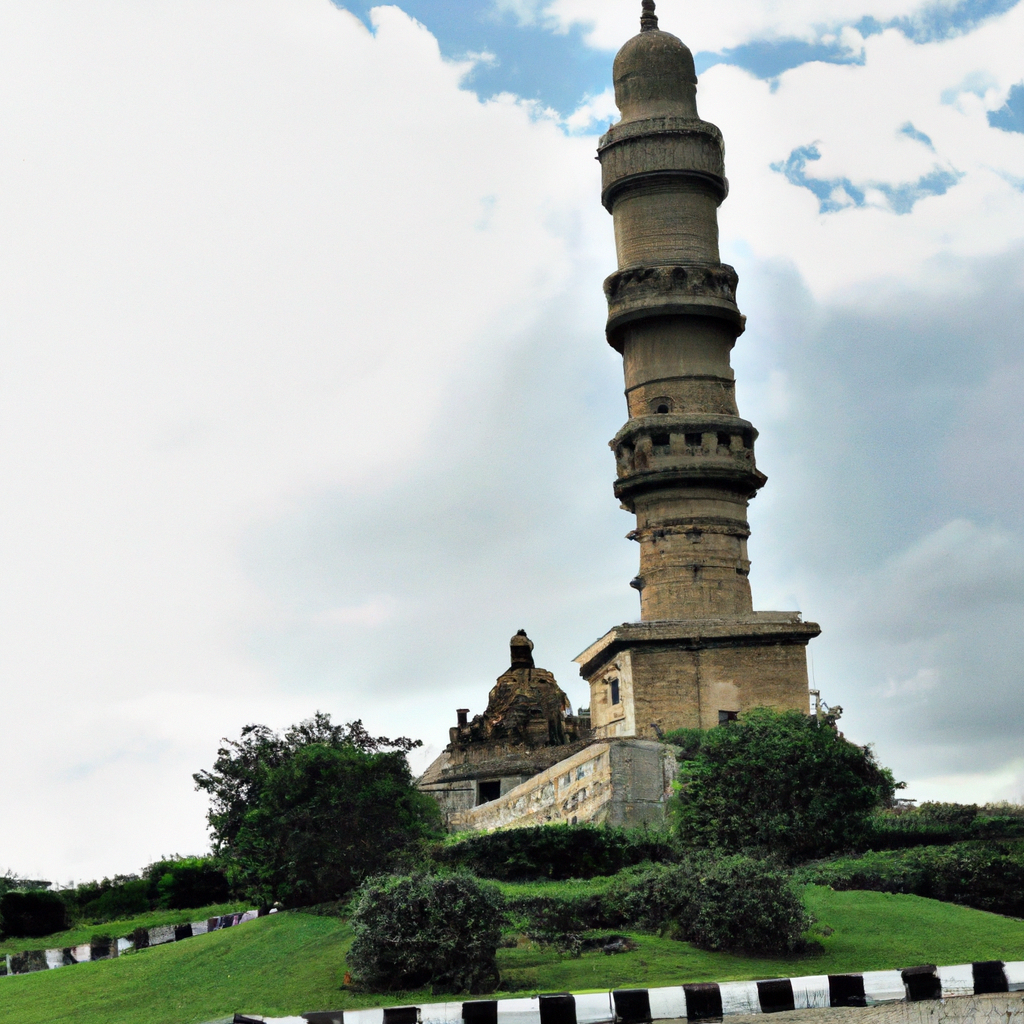

In [78]:
image=artist("hyderabad")
image

In [137]:
def talker(message):
    response=openai.audio.speech.create(model="gpt-4o-mini-tts",
    voice="onyx",
    input="messgae")
    return response.content

In [138]:
def chat(history):
    print(f"chat method called")
    history = [{"role":h["role"],"content":h["content"]} for h in history]
    messages = [{"role":"system","content":system_message}] + history 
    response=openai.chat.completions.create(model=MODEL,messages=messages,tools=tools)
    cities=[]
    image = None
    while response.choices[0].finish_reason=="tool_calls":
        print(f"inside the tool calls")
        message=response.choices[0].message
        responses,cities=handle_tool_calls_and_return_cities(message)
        messages.append(message)
        messages.extend(responses)
        print(f"messages got appended")
        response=openai.chat.completions.create(model=MODEL,messages=messages,tools=tools)
    reply=response.choices[0].message.content
    print(f"reply from final output is {reply}")
    history += [{"role":"assistant","content":reply}]

    voice=talker(reply)

    if(cities):
        image=artist(cities[0])
    
    return history,voice,image


        

In [131]:
def handle_tool_calls_and_return_cities(message):
    responses = []
    cities = []
    for tool_call in message.tool_calls:
        print(f"Inside the tool_calls loop")
        if tool_call.function.name == "get_ticket_price":
            print(f"function name evaluvated correctly")
            arguments = json.loads(tool_call.function.arguments)
            city=arguments.get('destination_city')
            cities.append(city)
            price_detail=get_ticket_price(city)
            responses.append({
                "role":"tool",
                "content": price_detail,
                "tool_call_id": tool_call.id
            })
    return responses,cities




In [139]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, auth=("RK", "bananas"))

* Running on local URL:  http://127.0.0.1:7936
* To create a public link, set `share=True` in `launch()`.


chat method called
reply from final output is Hello! How can I assist you with your flight today?
chat method called
reply from final output is Great choice! Would you like me to provide the price for a return ticket to Delhi?
chat method called
inside the tool calls
Inside the tool_calls loop
function name evaluvated correctly
Database tool called for the Delhi
messages got appended
reply from final output is The price for a return ticket to Delhi is $800.
